### UNet and SegNet 
### Task 2: 
    * Extend a UNet and a SegNet by adding residual connections in the encoder and decoder
    * Train the models and check the Dice coefficients

In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn

import torchsummary as summary


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
    
unet = UNet(in_channels=3, out_channels=2)
print(unet)
unet.cuda()
summary.summary(unet, (3, 256, 256))
test = torch.rand(1, 3, 256, 256).cuda()
unet(test)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

tensor([[[[-0.5217,  0.3626, -0.0403,  ...,  0.1423, -0.2762, -0.1289],
          [-0.0466,  0.0416, -0.0660,  ...,  0.0212, -0.2253,  0.1448],
          [ 0.3894,  0.4534,  0.0098,  ..., -0.4448,  0.3847,  0.4533],
          ...,
          [-0.0154,  0.0557,  0.0581,  ..., -0.2072,  0.4322,  0.0344],
          [ 0.0693,  0.2646,  0.2603,  ...,  0.1213, -0.5606,  0.1334],
          [-0.0414, -0.0269,  0.0443,  ...,  0.3844, -0.5279, -0.0216]],

         [[-0.7257, -0.7180, -0.4772,  ..., -0.6876, -0.6366, -0.7211],
          [-0.8394, -0.5561, -1.3861,  ..., -0.3784, -0.6809, -0.7418],
          [-0.9864, -0.8573, -1.2452,  ..., -0.4604, -0.4483,  0.0303],
          ...,
          [-0.9923, -0.1752, -1.4478,  ..., -0.5660, -0.7938,  0.0686],
          [-0.4316, -0.7457, -0.8881,  ..., -0.8723, -0.5873, -0.9424],
          [-0.2837, -0.3492, -0.4152,  ..., -0.6165, -0.2235, -0.1497]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [2]:
class SegNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(SegNet, self).__init__()

        features = init_features
        self.encoder1 = SegNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.encoder2 = SegNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.encoder3 = SegNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.encoder4 = SegNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.bottleneck = SegNet._block(features * 8, features * 16, name="bottleneck")
        self.pool_bottleneck = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.unpool_bottleneck = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec5 = SegNet._block(features * 16, features * 8, name="dec5")

        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        #self.upconv4 = nn.ConvTranspose2d(
        #    features * 16, features * 8, kernel_size=2, stride=2
        #)
        self.decoder4 = SegNet._block(features * 8 , features * 4, name="dec4")

        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        #self.upconv3 = nn.ConvTranspose2d(
        #    features * 8, features * 4, kernel_size=2, stride=2
        #)
        self.decoder3 = SegNet._block(features * 4 , features * 2, name="dec3")
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        #self.upconv2 = nn.ConvTranspose2d(
        #    features * 4, features * 2, kernel_size=2, stride=2
        #)
        self.decoder2 = SegNet._block(features * 2 , features , name="dec2")
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)

        #self.upconv1 = nn.ConvTranspose2d(
        #    features * 2, features, kernel_size=2, stride=2
        #)
        self.decoder1 = SegNet._block(features , features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        
        enc1_1, indices1 = self.pool1(enc1)  
        
        enc2 = self.encoder2(enc1_1)
        
        enc2_1, indices2 = self.pool2(enc2)
        
        enc3 = self.encoder3(enc2_1)
        
        enc3_1, indices3 = self.pool3(enc3)
        
        enc4 = self.encoder4(enc3_1)
        
        enc4_1, indices4 = self.pool4(enc4)
        
        bottleneck = self.bottleneck(enc4_1)
        
        bottleneck, indices_bottleneck = self.pool_bottleneck(bottleneck)
        
        bottleneck_unpool = self.unpool_bottleneck(bottleneck, indices_bottleneck)
        
        bottleneck = self.dec5(bottleneck_unpool)
        
        dec4 = self.unpool4(bottleneck, indices4)
        
        #dec4 = self.upconv4(bottleneck)
        #dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        #dec3 = self.upconv3(dec4)
        #dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.unpool3(dec4, indices3)
        dec3 = self.decoder3(dec3)
        #dec2 = self.upconv2(dec3)

        #dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.unpool2(dec3, indices2)
        dec2 = self.decoder2(dec2)
        dec1 = self.unpool1(dec2, indices1)
        #dec1 = self.upconv1(dec2)
        #dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )
segnet = SegNet(in_channels=3, out_channels=2)
print(segnet)
segnet.cuda()
summary.summary(segnet, (3, 256, 256))
test = torch.rand(1, 3, 256, 256).cuda()
segnet(test)

SegNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

tensor([[[[ 0.2430,  0.2955,  0.1316,  ..., -0.4427,  0.5850,  0.0862],
          [-0.0050,  0.5753, -0.0322,  ...,  0.1635, -0.5139,  0.3064],
          [-0.0365, -0.2918,  0.2542,  ..., -0.0663,  0.0374,  0.3722],
          ...,
          [ 0.1155,  0.2315,  0.8452,  ..., -0.1884, -0.1642,  0.3882],
          [-0.0481, -0.2769,  0.0111,  ...,  0.0276, -0.2462,  0.3786],
          [ 0.0682, -0.0276,  0.2929,  ...,  0.1230, -0.5458,  0.2230]],

         [[ 0.2089,  0.5464,  0.2899,  ...,  0.5966,  0.5673,  0.5280],
          [ 0.2634, -0.0646,  0.6331,  ...,  0.2267,  0.2330,  0.2089],
          [ 0.3110,  0.2823,  0.3419,  ...,  0.4564,  0.5015,  0.0962],
          ...,
          [ 0.2410,  0.1600,  0.2907,  ...,  0.0410,  0.0878,  0.2271],
          [ 0.4737,  0.7047,  0.2640,  ...,  0.1486,  0.7912,  0.1977],
          [ 0.3715,  0.3737,  0.3840,  ...,  0.2819,  0.5337,  0.3041]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [33]:
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision


all_img_path = "./leaves/data/data"
all_img_lst = os.listdir(all_img_path+"/images") # "./train"
all_mask_lst = os.listdir(all_img_path+"/masks") # "./train_masks"

#print(len(all_img_lst))
#print(len(all_mask_lst))

sorted_img_lst = sorted(all_img_lst)
sorted_mask_lst = sorted(all_mask_lst)

#print(sorted_img_lst[:5])
def show_images(imgs_lst,masks_lst,loops=2):
    for i in range(loops):
        img_path = os.path.join(all_img_path+"/images",imgs_lst[i])
        print(img_path)
        mask_path = os.path.join(all_img_path+"/masks",masks_lst[i])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        print(img_path)
        print(img.size)
        print(type(img))
        plt.imshow(img)
        plt.show()
        print(mask_path)
        print(mask.size)
        plt.imshow(mask)
        plt.show()
        print("----------------------------------------------------")

#show_images(sorted_img_lst, sorted_mask_lst)

train_idx, val_idx = train_test_split(list(range(len(sorted_img_lst))), test_size=0.2)

#print(len(train_idx))
#print(len(val_idx))
train_test_split = 0.8


train_img_lst = [sorted_img_lst[i] for i in train_idx]
train_mask_lst = [sorted_mask_lst[i] for i in train_idx]
val_img_lst = [sorted_img_lst[i] for i in val_idx]
val_mask_lst = [sorted_mask_lst[i] for i in val_idx]

transform_img = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256),interpolation=Image.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_mask = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256),interpolation=Image.NEAREST),
    torchvision.transforms.ToTensor()
])

class LeaveDataset(torch.utils.data.Dataset):
    def __init__(self, img_lst, mask_lst, img_path, mask_path, transform_img=transform_img, transform_mask=transform_mask):
        self.img_lst = img_lst
        self.mask_lst = mask_lst
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.img_lst)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_path, self.img_lst[idx])
        mask_path = os.path.join(self.mask_path, self.mask_lst[idx])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        mask= mask.convert('L')
        mask = np.array(mask)
        mask[mask>0] = 255
        mask[mask==0] = 0
        mask = Image.fromarray(mask)
        
        img = self.transform_img(img)
        mask = self.transform_mask(mask)
        
        return img, mask
    
train_dataset = LeaveDataset(train_img_lst, train_mask_lst, all_img_path+"/images", all_img_path+"/masks")
val_dataset = LeaveDataset(val_img_lst, val_mask_lst, all_img_path+"/images", all_img_path+"/masks")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)


In [37]:
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from monai.losses import DiceLoss



def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().cuda()
        
        mask = img_mask[1].float().cuda()
        
        y_pred = model(img)
       
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        
        
        train_running_loss += loss.item() 
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss

def val_model(model,dataloader,criterion):
    model.eval()
    val_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().cuda()
        
        mask = img_mask[1].float().cuda()
        
        y_pred = model(img)
        
        loss = criterion(y_pred,mask)
        
        val_running_loss += loss.item() 
        
    val_loss = val_running_loss / (j+1)
    return val_loss

model = SegNet(3, 1).cuda()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.BCEWithLogitsLoss()
criterion = DiceLoss(sigmoid=True)

train_loss_lst = []
val_loss_lst = []  

for epoch in range(20):
    val_loss= 0
    train_loss = train_model(model,train_loader,criterion,optimizer)
    val_loss = val_model(model,val_loader,criterion)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    print(f"Epoch: {epoch}, Train loss: {train_loss}, Val loss: {val_loss}")



100%|██████████| 470/470 [00:06<00:00, 77.90it/s] 


Epoch: 0, Train loss: 0.7485952898859978, Val loss: 0.7954186737537384


100%|██████████| 470/470 [00:05<00:00, 79.96it/s] 


Epoch: 1, Train loss: 0.6718902662396431, Val loss: 0.8158564818666336


100%|██████████| 470/470 [00:06<00:00, 78.31it/s] 


Epoch: 2, Train loss: 0.6446482241153717, Val loss: 0.6813266424422568


100%|██████████| 470/470 [00:05<00:00, 78.96it/s] 


Epoch: 3, Train loss: 0.6282661631703377, Val loss: 0.6407385242746232


100%|██████████| 470/470 [00:05<00:00, 79.85it/s] 


Epoch: 4, Train loss: 0.6180901825428009, Val loss: 0.6226946129443798


100%|██████████| 470/470 [00:05<00:00, 78.55it/s] 


Epoch: 5, Train loss: 0.5988706797361374, Val loss: 0.5768425335275366


100%|██████████| 470/470 [00:06<00:00, 76.04it/s] 


Epoch: 6, Train loss: 0.5905416011810303, Val loss: 0.5863564205930588


100%|██████████| 470/470 [00:05<00:00, 80.54it/s] 


Epoch: 7, Train loss: 0.5770328864455223, Val loss: 0.5741703553402677


100%|██████████| 470/470 [00:05<00:00, 80.60it/s] 


Epoch: 8, Train loss: 0.5693191289901733, Val loss: 0.5555930108466047


100%|██████████| 470/470 [00:05<00:00, 80.38it/s] 


Epoch: 9, Train loss: 0.5625678822398186, Val loss: 0.5346273485650408


100%|██████████| 470/470 [00:05<00:00, 79.43it/s] 


Epoch: 10, Train loss: 0.5468813106417656, Val loss: 0.56733235146137


100%|██████████| 470/470 [00:06<00:00, 76.78it/s] 


Epoch: 11, Train loss: 0.5305466875433922, Val loss: 0.5283840707007875


100%|██████████| 470/470 [00:05<00:00, 79.40it/s] 


Epoch: 12, Train loss: 0.5214428268373013, Val loss: 0.5102670817933184


100%|██████████| 470/470 [00:05<00:00, 79.67it/s] 


Epoch: 13, Train loss: 0.5070752948522568, Val loss: 0.5018564698543955


100%|██████████| 470/470 [00:05<00:00, 79.61it/s] 


Epoch: 14, Train loss: 0.49387284740805626, Val loss: 0.4856593843470228


100%|██████████| 470/470 [00:05<00:00, 78.38it/s] 


Epoch: 15, Train loss: 0.49056940898299217, Val loss: 0.487544259111932


100%|██████████| 470/470 [00:05<00:00, 78.65it/s] 


Epoch: 16, Train loss: 0.488463819026947, Val loss: 0.4976612037800728


100%|██████████| 470/470 [00:05<00:00, 79.52it/s] 


Epoch: 17, Train loss: 0.47181010618805885, Val loss: 0.476422040766858


100%|██████████| 470/470 [00:05<00:00, 79.22it/s] 


Epoch: 18, Train loss: 0.4590226784348488, Val loss: 0.44182113066632694


100%|██████████| 470/470 [00:06<00:00, 77.20it/s] 

Epoch: 19, Train loss: 0.46606898307800293, Val loss: 0.4855414268818307


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


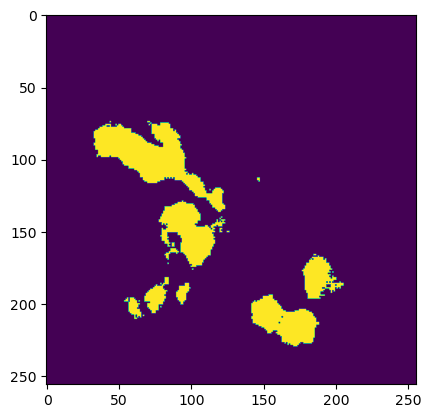

0.0 1.0


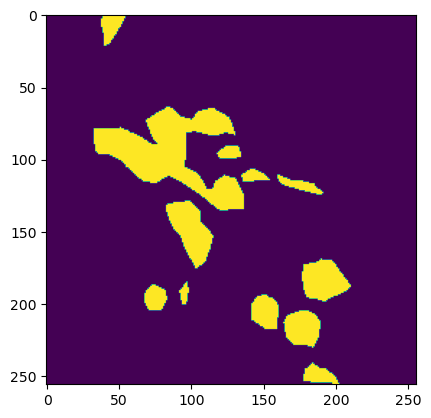

In [36]:
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

val_img = next(iter(val_loader))[0].cuda()
val_mask = next(iter(val_loader))[1].cuda()



val_pred = model(val_img)
val_pred = torch.sigmoid(val_pred)
val_pred = val_pred.detach().cpu().numpy()
val_pred = np.squeeze(val_pred)
#val_pred = np.transpose(val_pred, (1, 2, 0))
val_pred = np.squeeze(val_pred)
val_pred = np.where(val_pred > 0.5, 1, 0)
print(val_pred)
plt.imshow(val_pred)
plt.show()
val_mask = val_mask[0].cpu().numpy().squeeze()
print(val_mask.min(), val_mask.max())
plt.imshow(val_mask)
plt.show()
#plt.imshow(val_img[0].cpu().numpy().squeeze().transpose(1,2,0))